In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from enum import StrEnum

## Отбор наблюдений в выборку

In [4]:
data = pd.read_csv('final_products_05_05_2025_09_59.csv')
data = data[(data['Вес (кг)'] <= 0.1) & (data['Вес (кг)']>= 0.075)]
data = data[data['Тип'] == 'Шоколадная плитка']
data = data.reset_index()[['Название', 'Текущая цена', 'Бренд', 'Рейтинг', 'Ккал', 'Упаковка', 'Тип шоколада', 'Какао (%)', \
        'Состав']].rename(columns={'Название': 'name', 'Текущая цена': 'price', 'Бренд': 'brand', 'Рейтинг': 'rating', 'Ккал': 'kcal', \
        'Упаковка': 'package', 'Тип шоколада': 'type', 'Какао (%)': 'cocoa', 'Состав': 'Состав'})
data.head(5)

,name,price,brand,rating,kcal,package,type,cocoa,Состав
0,Шоколад белый Миндаль и кокос Alpen Gold 80г,74.99,Alpen Gold,4.8,545.0,флоупак,Белый,22.0,"Сахар, масло какао, сыворотка сухая молочная, ..."
1,Шоколад белый пористый Россия щедрая душа 75г,74.99,Россия Щедрая Душа,4.8,545.0,флоупак,Белый,25.0,"Сахар, масло какао, молоко сухое цельное, сыво..."
2,Шоколад Классический Чизкейк Alpen Gold 85/90г,74.99,Alpen Gold,4.8,533.0,флоупак,Молочный,25.0,"Сахар, жир растительный (масло пальмовое), печ..."
3,Шоколад молочный Россия щедрая душа 82г,79.99,Россия Щедрая Душа,4.8,539.0,флоупак,Молочный,27.0,"Сахар, масло какао, молоко сухое цельное, кака..."
4,Шоколад белый Gold Selection Дуэт в клубнике Р...,88.99,Россия Щедрая Душа,4.8,543.0,флоупак,Белый,20.0,"Сахар, масло какао, молоко сухое цельное, сыво..."


## Формирование и графический анализ признаков

### Российский бренд:

In [8]:
rus_brands = ['Alpen Gold', 'Россия Щедрая Душа', 'Бабаевский', 'Степ', 'Особый', 'Babyfox', 'Алёнка', 'Milk Story', 'Хрутка', 'Победа', \
        'Ozera', 'Вдохновение', 'Eco Botanica', 'Dy Nastie', 'Победа Вкуса', 'Red Delight', 'Белочка', 'Libertad', 'Рот Фронт', 'Славянка', \
       'Монетный Двор', 'Развивайка']
data['rus_brand'] = data['brand'].map(lambda x: 1 if x in rus_brands else 0)

In [10]:
round((data['rus_brand'].sum() / data.shape[0]) * 100, 2)

60.12

60.12% всех шоколадок в выборке выпускаются российскими брендами.

### Тип шоколада:

In [14]:
data['type'].value_counts(dropna=False)

type
Молочный    103
Темный       28
Горький      18
Белый        14
NaN           5
Name: count, dtype: int64

Для 5 наблюдений из выборки значение данного признака пропущено. Посмотрим на данные наблюдения подробнее.

In [17]:
data[data['type'].isna()][['name', 'type']]

,name,type
9,Шоколад молочный и белый пористый Россия щедра...,NaN
16,Шоколад Трилогия Schogetten 100г,NaN
37,Шоколад Мороженое Schogetten 100г,NaN
156,Набор Маша и медведь шоколадный молочный Монет...,NaN
157,Шоколад молочный набор Развивайка 75г,NaN


В 3 из данных шоколадок действительно смешаны несколько типов шоколада, поэтому однозначно отнести их к одному из типов не получится. Оставшиеся 2 не являются классическими шоколадными плитками и выпускаются в подарочной упаковке, что может привести к гетероскедастичности, поэтому разумно было бы исключить данные наблюдения уже сейчас. Так как наблюдений с пропущенным значением всего 5, можем удалить их из выборки во избежание нарушения методологии.

In [20]:
data = data[~data['type'].isna()].reset_index().drop(columns='index')

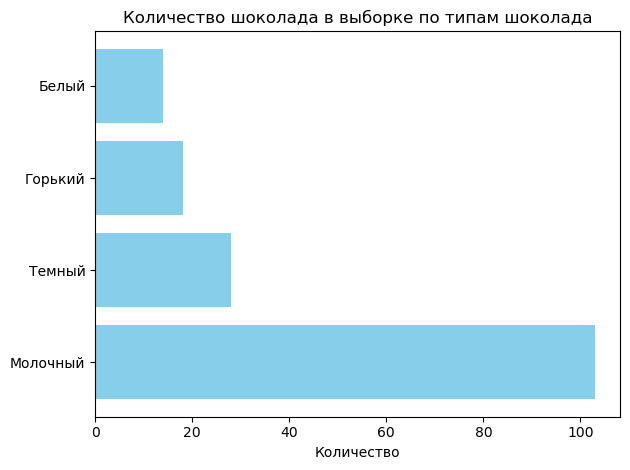

In [22]:
freq = data['type'].value_counts()
plt.barh(freq.index, freq, color='skyblue')

plt.xlabel('Количество')
plt.title('Количество шоколада в выборке по типам шоколада')

plt.tight_layout()
plt.show()

### Калорийность:

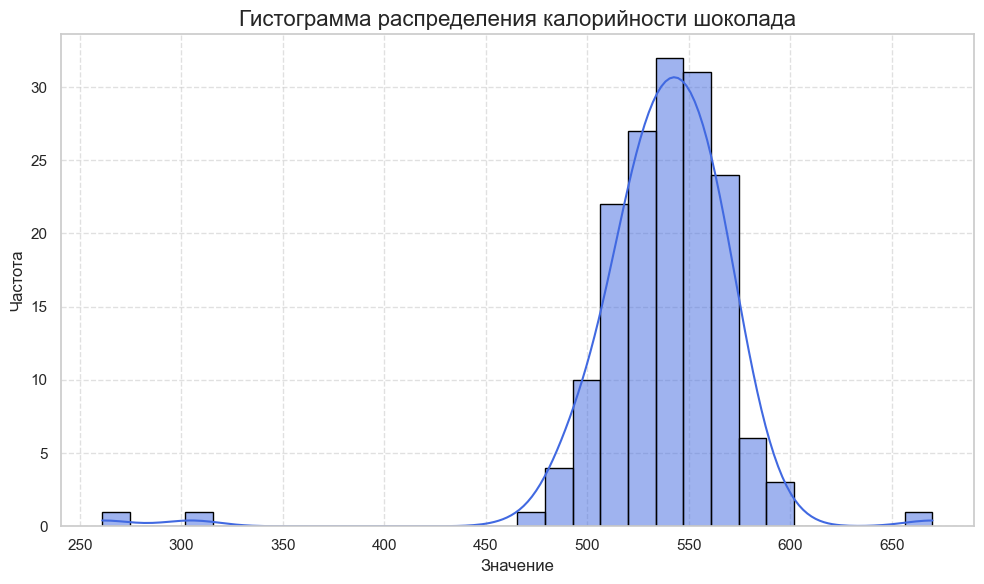

In [25]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(data['kcal'], bins=30, kde=True, color='royalblue', edgecolor='black')

plt.title('Гистограмма распределения калорийности шоколада', fontsize=16)
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [27]:
desc = pd.DataFrame(data['kcal'].describe())
desc_df = desc.transpose()
pd.DataFrame(desc_df).drop(columns='count')

,mean,std,min,25%,50%,75%,max
kcal,537.196319,38.424988,261.0,521.5,540.0,559.0,670.0


Как можно увидеть, калорийность для всех наблюдений кроме 3 сосредоточена между 470 и 593. Описательные статистики приведены выше.

### Добавки:

Будем доставать информацию о имеющихся добавках из названий шоколадок при помощи LLM. Определим 5 основных категорий добавок:
1. Орехи
2. Ягоды и сухофрукты
3. Снеки
4. Десертные начинки
5. Экзотические начинки

Для каждой шоколадки соберем список из имеющихся добавок в соответствии с категориями выше.

In [32]:
def filling(name):    
    class Type(StrEnum):
        NUTS = "NUTS"
        BERRIES = "BERRIES"
        SNACKS = "SNACKS"
        DESSERT = "DESSERT"
        EXOTIC = "EXOTIC"
        NO_FILLING = "NO_FILLING"
    
    class AIOutput(BaseModel):
        Types: list[Type]
    
    text_prompt = """
        У тебя есть название шоколадки. Определи все начинки, содержащиеся в шоколаде, по категориям, представленным ниже.
        То есть отнести все элементы из начинки шоколадки по соответствующим категориям, после чего верни список из всех категорий,
        элементы которых встречаются в начинке шоколадки.
        
        1. NUTS, если начинка содержит орехи, например:
        Миндаль, Фундук, Лесной орех, Кешью , Арахис, Фисташки, Грецкий орех
        При этом, если начинка является десертной со вкусом ореха, тебе не стоит относить начинку к данной категории.
        
        2. BERRIES, если начинка содержит ягоды или сухофрукты, например: 
        Клубника, Малина, Вишня, Черника, Клюква, Изюм  
        При этом, если ягода используется в йогуртовой начинке, тебе не стоит относить начинку к данной категории
        
        3. SNACKS, если начинка содержит печенье, вафли или другие хрустящие элементы, например:  
        Печенье, Вафли, Воздушный рис, Хлопья
        
        4. DESSERT, если начинка содержит йогуртовую или десертную начинку, например: 
        Йогуртные начинки с разными вкусами, начинки помадка, тирамису, крем-брюле и тд 
        
        5. EXOTIC, если начинка является достаточно экзотической и нечасто встречается в шоколаде, например:
        Лаванда, Роза, Мёд, Матча, Тыквенные семечки, Кунжут и т.д.
        
        6. NO_FILLING, если шоколад не содержит никакой начинки из вышеперечисленных категорий
    
        Название шоколадки:
                {name}
    
        <FORMAT_INSTRUCTIONS>:
                {format_instructions}
    """
    
    
    model = ChatOpenAI(model="gpt-4.1", api_key=OPENAI_API_KEY)
    parser = PydanticOutputParser(pydantic_object=AIOutput)
    
    prompt = PromptTemplate(
        template=text_prompt,
        input_variables=["name"],
        partial_variables={
            "format_instructions": parser.get_format_instructions(),
        }
    )
    
    chain = prompt | model | parser
    
    result = chain.invoke({
            "name": name
            })
    
    ans = []
    for t in result.Types:
        ans.append(str(t))

    return ans

In [34]:
# data['filling'] = data['name'].map(lambda x: filling(x))
# filling = {data.loc[ind]['name']: data.loc[ind]['filling'] for ind in data.index}
# with open('fillings.json', "w", encoding="utf-8") as json_file:
#     json.dump(filling, json_file, indent=4, ensure_ascii=False)

In [36]:
with open('fillings.json', "r", encoding="utf-8") as json_file:
     filling = json.load(json_file)

In [38]:
data['filling'] = data['name'].map(filling)
data['filling_NUTS'] = data['filling'].map(lambda x: 1 if 'NUTS' in x else 0)
data['filling_BERRIES'] = data['filling'].map(lambda x: 1 if 'BERRIES' in x else 0)
data['filling_SNACKS'] = data['filling'].map(lambda x: 1 if 'SNACKS' in x else 0)
data['filling_DESSERT'] = data['filling'].map(lambda x: 1 if 'DESSERT' in x else 0)
data['filling_EXOTIC'] = data['filling'].map(lambda x: 1 if 'EXOTIC' in x else 0)

In [40]:
round((data['filling_NUTS'].sum() / data.shape[0]) * 100, 2)

44.17

44.17% всех шоколадок в выборке содержат орехи в начинке.

In [43]:
round((data['filling_BERRIES'].sum() / data.shape[0]) * 100, 2)

14.11

14.11% всех шоколадок в выборке содержат ягоды или сухофрукты в начинке.

In [46]:
round((data['filling_SNACKS'].sum() / data.shape[0]) * 100, 2)

13.5

13.5% всех шоколадок в выборке содержат снеки в начинке.

In [49]:
round((data['filling_DESSERT'].sum() / data.shape[0]) * 100, 2)

22.7

27.7% всех шоколадок в выборке содержат десертную начинку.

In [52]:
round((data['filling_EXOTIC'].sum() / data.shape[0]) * 100, 2)

16.56

16.56% всех шоколадок в выборке содержат нестандартную начинку.

### Содержание какао:

In [56]:
data['cocoa'].isna().sum()

22

Для 22 наблюдений из выборки значение данного признака пропущено. Посмотрим на данные наблюдения подробнее.

In [59]:
data[data['cocoa'].isna()]

,name,price,brand,rating,kcal,package,type,cocoa,Состав,rus_brand,filling,filling_NUTS,filling_BERRIES,filling_SNACKS,filling_DESSERT,filling_EXOTIC
24,Шоколад White Chocolate белый Schogetten 100г,134.99,Schogetten,4.9,555.0,картонная упаковка,Белый,NaN,"Сахар, какао-масло, сухое обезжиренное молоко,...",0,[NO_FILLING],0,0,0,0,0
35,Шоколад Aerated белый пористый Alpen Gold 75г,89.99,Alpen Gold,4.8,527.0,флоупак,Белый,NaN,"Сахар, масло какао, сыворотка сухая молочная, ...",1,[NO_FILLING],0,0,0,0,0
40,Шоколад молочный с кокосовой начинкой и вафлей...,59.99,Milk Story,4.6,550.0,флоупак,Молочный,NaN,"Сахар, масло пальмовое, масло какао, сыворотка...",1,"[SNACKS, EXOTIC]",0,0,1,0,1
42,Шоколад белый Schogetten Chai Latte 100г,149.99,Schogetten,4.2,561.0,картонная упаковка,Белый,NaN,"Сахар, пальмовый жир, сухое цельное молоко, ка...",0,"[DESSERT, EXOTIC]",0,0,0,1,1
64,Шоколад Клубничный йогурт Schogetten 100г,119.99,Schogetten,4.8,563.0,картонная упаковка,Молочный,NaN,"Сахар, пальмовый жир, какао-масло, сухое йогур...",0,[DESSERT],0,0,0,1,0
67,Шоколад молочный Popcorn Schogetten 100г,149.99,Schogetten,4.7,554.0,картонная упаковка,Молочный,NaN,"Сахар, пальмовый жир, сухое цельное молоко, ка...",0,[SNACKS],0,0,1,0,0
69,Шоколад молочный Соленая карамель Ritter Sport...,159.99,Ritter Sport,4.8,535.0,флоупак,Молочный,NaN,"Сахар, масло какао, какао тертое, соленая кара...",0,[DESSERT],0,0,0,1,0
70,Шоколад белый с лимонной начинкой Ritter Sport...,169.99,Ritter Sport,4.7,589.0,флоупак,Белый,NaN,"Шоколад белый (сахар, масло какао, сухое цельн...",0,[EXOTIC],0,0,0,0,1
79,Шоколад молочный с хрустящими шариками Хрутка 88г,98.99,Хрутка,4.5,543.0,флоупак,Молочный,NaN,"Сахар, молоко сухое цельное, жир специального ...",1,[SNACKS],0,0,1,0,0
83,Шоколад молочный с ореховой нугой Schogetten 100г,149.99,Schogetten,4.7,547.0,картонная упаковка,Молочный,NaN,"Сахар, масло какао, паста из фундука (13%), су...",0,"[NUTS, DESSERT]",1,0,0,1,0


По результатам поиска в интернете процента содержания какао для каждой из шоколадок выше, можем заполнить пропуски. 

In [62]:
def fillna_cocoa(row):
    if row['type'] == 'Белый':
        return 0
    if row['type'] == 'Молочный' and row['brand'] == 'Schogetten':
        return 30
    if row['type'] == 'Молочный' and row['brand'] == 'Ritter Sport':
        return 33
    if row['type'] == 'Молочный' and row['brand'] == 'Алёнка':
        return 30
    if row['brand'] == 'Kinder':
        return 13
    if row['type'] == 'Темный' and row['brand'] == 'Schogetten':
        return 50
    if row['type'] == 'Молочный':
        return 30
    if row['type'] == 'Горький':
        return 75

In [64]:
data['cocoa'] = data.apply(lambda x: fillna_cocoa(x) if pd.isna(x['cocoa']) else x['cocoa'], axis=1)

In [66]:
data['cocoa'].isna().sum()

0

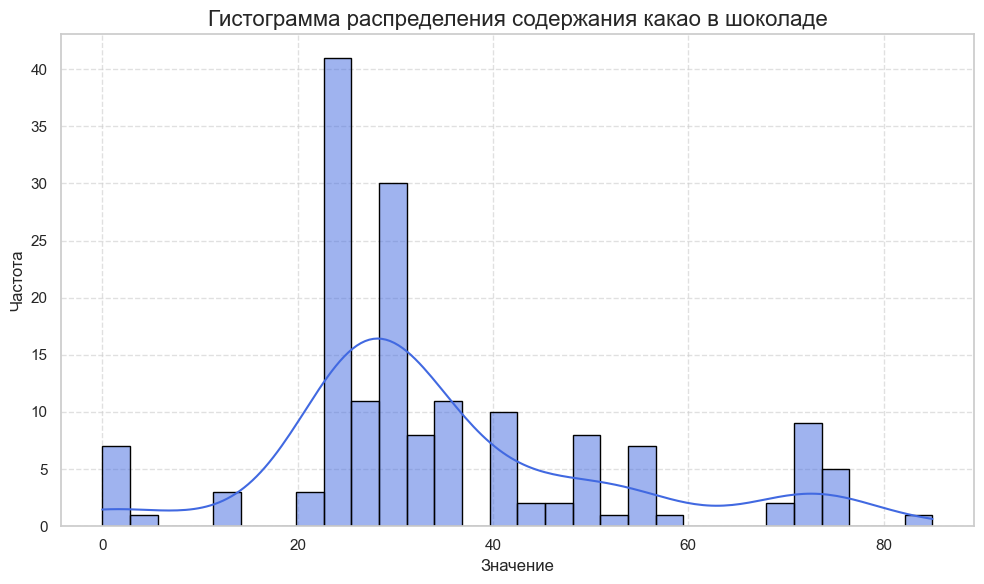

In [68]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(data['cocoa'], bins=30, kde=True, color='royalblue', edgecolor='black')

plt.title('Гистограмма распределения содержания какао в шоколаде', fontsize=16)
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [69]:
desc = pd.DataFrame(data['cocoa'].describe())
desc_df = desc.transpose()
pd.DataFrame(desc_df).drop(columns='count')

,mean,std,min,25%,50%,75%,max
cocoa,35.006135,17.311773,0.0,25.0,30.0,41.5,85.0


Наблюдаются толстые левый и правый хвосты распределения -- это белый и горький шоколад соответственно. В выборке преобладает молочный шоколад.

### Упаковка:

In [74]:
data['package'].value_counts(dropna=False)

package
флоупак               93
картонная упаковка    47
бумажная упаковка     23
Name: count, dtype: int64

In [76]:
data['package'].isna().sum()

0

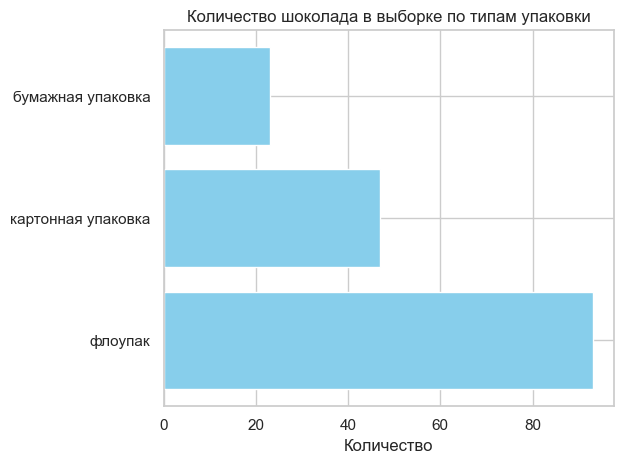

In [78]:
freq = data['package'].value_counts()
plt.barh(freq.index, freq, color='skyblue')

plt.xlabel('Количество')
plt.title('Количество шоколада в выборке по типам упаковки')

plt.tight_layout()
plt.show()

### Рейтинг:

In [81]:
data['rating'].isna().sum()

12

Для 12 наблюдений из выборки рейтинг товара отсутствует. Посмотрим на распределение данного признака.

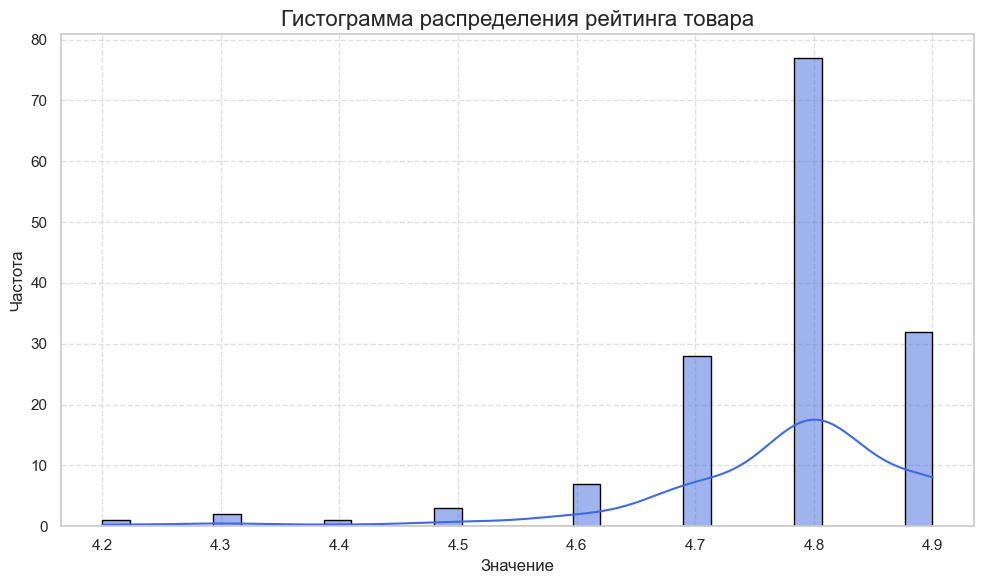

In [84]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(data['rating'], bins=30, kde=True, color='royalblue', edgecolor='black')

plt.title('Гистограмма распределения рейтинга товара', fontsize=16)
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [85]:
desc = pd.DataFrame(data['rating'].describe())
desc_df = desc.transpose()
pd.DataFrame(desc_df).drop(columns='count')

,mean,std,min,25%,50%,75%,max
rating,4.774172,0.117453,4.2,4.7,4.8,4.8,4.9


Видно, что для подавляющего большинства товаров рейтинг равен 4.8. Поэтому закодируем данным значением пропущенные значения.

In [89]:
data['rating'] = data['rating'].fillna(data['rating'].mode()[0])

### Наличие эмульгаторов:

Добавим также в признаковое описание дамми-переменную на наличие эмульгаторов в составе шоколада.

In [93]:
def emulsifier(text):
    for i in range(len(text) - 1):
        if text[i] == 'Е' and text[i + 1] in '1234567890':
            return 1
    return 0

In [95]:
data['emulsifiers'] = data['Состав'].map(lambda x: emulsifier(x))

In [97]:
round((data['emulsifiers'].sum() / data.shape[0]) * 100, 2)

44.17

44.17% шоколадок в выборке содержат в своем составе эмульгаторы.

### Отсуствие сахара:

Добавим в признаковое описание дамми-переменную на отсутствие сахара в составе шоколада.

In [102]:
def no_sugar(text):
    for i in range(len(text) - 5):
        if text[i:i+5].lower() == 'сахар':
            return 0
    return 1

In [104]:
data['no_sugar'] = data['Состав'].map(lambda x: no_sugar(x))

In [106]:
round((data['no_sugar'].sum() / data.shape[0]) * 100, 2)

1.23

### Цена.

Теперь посмотрим на распределение целевой переменной.

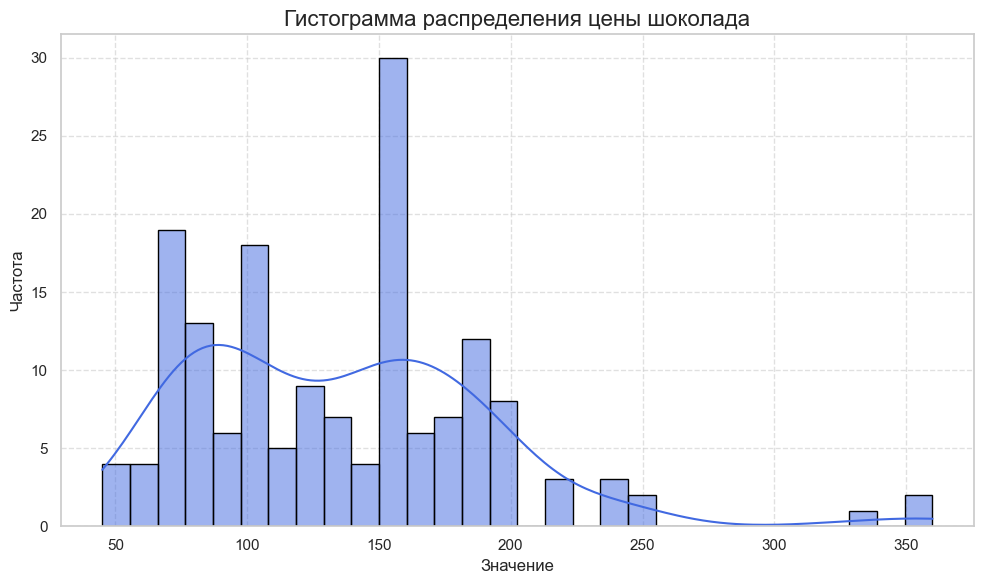

In [110]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=30, kde=True, color='royalblue', edgecolor='black')

plt.title('Гистограмма распределения цены шоколада', fontsize=16)
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [111]:
desc = pd.DataFrame(data['price'].describe())
desc_df = desc.transpose()
pd.DataFrame(desc_df).drop(columns='count')

,mean,std,min,25%,50%,75%,max
price,135.327423,56.643483,44.99,89.49,129.99,169.99,359.99


Выделяются 3 явных ценовых кластера, что, в том числе, можно увидеть по ядерной оценке плотности.

## Формирование датасета:

In [118]:
data[['name', 'price', 'rus_brand', 'rating', 'no_sugar', 'kcal', 'package', 'type', 'cocoa', 'filling_NUTS', 'filling_BERRIES', \
       'filling_SNACKS', 'filling_DESSERT', 'filling_EXOTIC', 'emulsifiers']].to_csv('chocolate_data.csv', index=False)